<a href="https://colab.research.google.com/drive/1XzonkFgEYrcHE29GiqWdwnGtML3mbYBk?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DDSP Components

Many DSP operations can be expressed as functions in modern automatic differentiation software. We express core components as feedforward functions, allowing efficient implementation on parallel hardware such as GPUs and TPUs, and generation of samples during training. 

These components include oscillators, envelopes, and filters (linear-time-varying finite-impulse-response, LTV-FIR).


<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


###Install and import dependencies

In [1]:
%tensorflow_version 2.x
!pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (play, record, specplot, upload, 
                                    transfer_function, 
                                    plot_impulse_responses, 
                                    DEFAULT_SAMPLE_RATE)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

     |████████████████████████████████| 174kB 5.7MB/s 
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 215kB 12.4MB/s 
     |████████████████████████████████| 3.8MB 16.1MB/s 
     |████████████████████████████████| 3.6MB 29.1MB/s 
     |████████████████████████████████| 5.6MB 25.2MB/s 
     |████████████████████████████████| 20.2MB 7.3MB/s 
     |████████████████████████████████| 378kB 42.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
ERROR: pynndescent 0.5.2 has requirement numba>=0.51.2, but you'll have numba 0.49.1 which is incompatible.


# Spectral Modeling Synthesis

This model generates sound by combining an additive
synthesizer (adding together many sinusoids) with a subtractive synthesizer (filtering white noise).
We choose SMS because, despite being parametric, it is a highly expressive model of sound, and has
found widespread adoption in tasks as diverse as spectral morphing, time stretching, pitch shifting,
source separation, transcription, and even as a general purpose audio codec in MPEG-4.

As we only consider monophonic sources in these experiments, we use the **Harmonic plus Noise model**, that further constrains sinusoids to be integer multiples of a **fundamental frequency**.

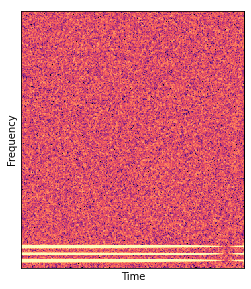

In [ ]:
n_samples = int(sample_rate * 4.0)
n_components = 3

# Amplitudes [n_batch, n_samples, n_components].
# Linearly decay in time.
amps = np.linspace(0.3, 0.0, n_samples)
#print(amps,'\n')
amps = np.tile(amps[np.newaxis, :, np.newaxis], [1, 1, n_components]) # expand dimensions
#print(amps)

# Frequencies in Hz [n_batch, n_samples, n_components].
frequencies = np.ones([1, n_samples, 1]) * np.array([[[220, 440, 660]]])

# Sythesize.
noise = np.random.uniform(-0.050, 0.005, [1,n_samples,3])#uniform(low,high,size)
#print('noise','\n',noise)
amps=amps+noise
audio = ddsp.core.oscillator_bank(frequencies, amps, sample_rate) # generate 3 sinusoid signals with different frequencies

# Listen.
play(audio)
specplot(audio)

# Harmonic Oscillation / Additive Synthesizer

At the heart of the synthesis techniques explored in this paper is the sinusoidal oscillator. A bank of oscillators that outputs a signal x(n) over discrete time steps, n, can be expressed as:

$x(n)=\sum_{k=1}^K A_k(n)sin(\phi_k(n))$

where $A_k (n)$ is the time-varying amplitude of the k-th sinusoidal component and $\phi_k(n)$ is its instantaneous phase. The phase $\phi_k(n)$ is obtained by integrating the instantaneous frequency $f_k (n)$:

$\phi_k(n)=2\pi\sum_{m=0}^n f_k(m)+\phi_{0,k}$

where $\phi_{0,k}$ is the initial phase that can be randomized, fixed, or learned.
For a harmonic oscillator, all the sinusoidal frequencies are harmonic (integer) multiples of a fundamental frequency, $f_0 (n)$, i.e., $f_k (n) = kf_0 (n)$, Thus the output of the harmonic oscillator is entirely parameterized by the time-varying fundamental frequency $f_0 (n)$ and harmonic amplitudes $A_k(n)$. To aid interpretablity we further factorize the harmonic amplitudes:

$A_k(n)=A(n)c_k(n) \qquad  where \sum_{k=0}^K c_k(n)=1$


(1, 1000, 1)
(1, 1000, 1)
(1, 1000, 20)


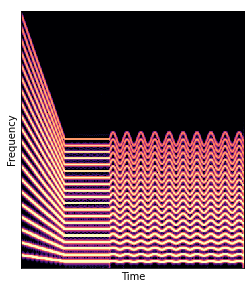

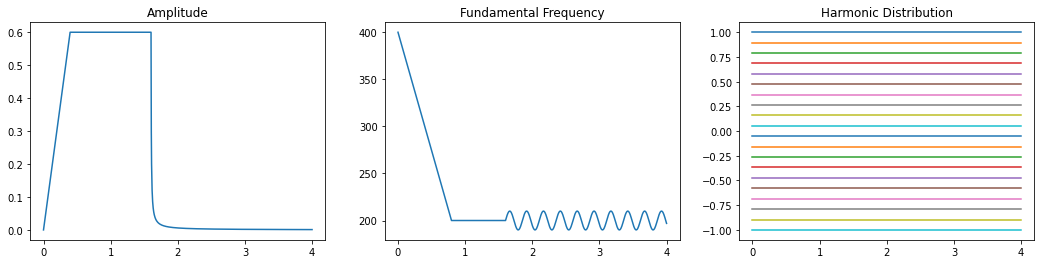

In [ ]:
# Generate some arbitrary inputs.

n_frames=1000

# Amplitude [batch, n_frames, 1].
# Make amplitude changes over time.
amps = np.concatenate((np.linspace(0,3,int(n_frames/10)),3*np.ones(int(3/10*n_frames)),3*1/((np.linspace(0,int(n_frames/10*6),int(n_frames/10*6)))+1)),axis=0)
amps = 0.2*amps[np.newaxis, :, np.newaxis]
print(amps.shape)


# decide the base frequency which varies with frame.
f0_hz=np.concatenate((np.linspace(400,200,int(n_frames/5)),200*np.ones(int(n_frames/5)),200+10*np.sin(0.1*np.linspace(0,int(3/5*n_frames),int(3/5*n_frames)))),axis=0)
f0_hz=f0_hz[np.newaxis,:,np.newaxis]
print(f0_hz.shape)

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics keep the same distribution with frequency.
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]
print(harmonic_distribution.shape)


# Create synthesizer object.
harmonic_synth = ddsp.synths.Harmonic(n_samples=n_samples,
                                      scale_fn=ddsp.core.exp_sigmoid,
                                      sample_rate=sample_rate)

# Generate some audio.
audio = harmonic_synth(amps, harmonic_distribution, f0_hz)

# Listen.
play(audio)
specplot(audio)

# Plot it!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(133)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(132)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')

# Envelopes

**Upsample** signal with overlapping hann windows (like an inverse [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)). Good for smooth amplitude envelopes.

The amplitudes and harmonic distributions of the additive synthesizer required smoothing to prevent artifacts. We are able to achieve this with a smoothed amplitude envelope by adding **overlapping Hamming windows** at the center of
each frame and scaled by the amplitude.

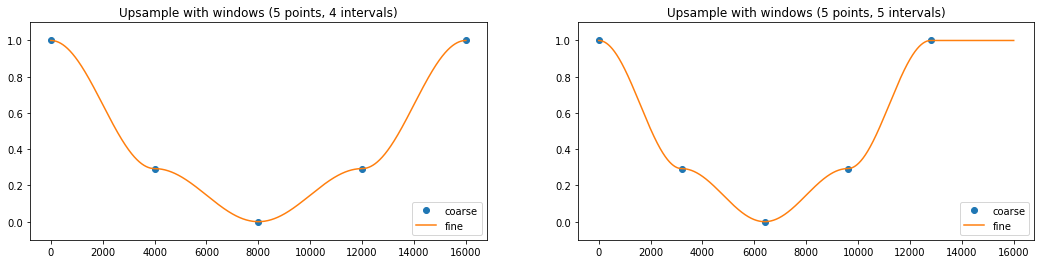

In [ ]:
n_coarse = 5
n_fine = 16000

coarse = 1.0 - np.sin(np.linspace(0, np.pi, n_coarse))[np.newaxis, :, np.newaxis]
fine = ddsp.core.upsample_with_windows(coarse, n_fine, add_endpoint=False)

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(np.linspace(0, n_fine, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine[0, :, 0], label='fine')
plt.title('Upsample with windows ({} points, {} intervals)'.format(n_coarse, n_coarse - 1))
plt.legend(loc='lower right')
_ = plt.ylim(-0.1, 1.1)


coarse = 1.0 - np.sin(np.linspace(0, np.pi, n_coarse))[np.newaxis, :, np.newaxis]
fine = ddsp.core.upsample_with_windows(coarse, n_fine)

n_intervals = (n_coarse - 1)
n_forward = int(n_fine / n_coarse * n_intervals)
plt.subplot(122)
plt.plot(np.linspace(0, n_forward, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine[0, :, 0], label='fine')
plt.title('Upsample with windows ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
_ = plt.ylim(-0.1, 1.1)

#  Filter Design: Frequency Sampling Method


---- This session partly refers to the colab tutorial[ 1_synths_and_effects](https://colab.research.google.com/drive/17idRTux3Hie3T8fgJ6RbRGKJ3OnXddVJ#scrollTo=Lay_6Ldw93ZL) provided by DDSP Github ----

Linear filter design is a cornerstone of many DSP techniques. Standard convolutional layers are equivalent to linear time invariant finite impulse response [(LTI-FIR) filters](https://www.gaussianwaves.com/2020/02/introduction-to-digital-filter-design/). However, to ensure **interpretability and prevent phase distortion**, we employ the **frequency sampling method** to convert network outputs into impulse responses of linear-phase filters.

FIR filter design method used by `ddsp.frequency_filter()`. Uses the frequency sampling method of filter design as described [here]( https://ccrma.stanford.edu/~jos/sasp/Windowing_Desired_Impulse_Response.html).

[Function](https://github.com/magenta/ddsp/blob/master/ddsp/effects.py) we use: 
* ddsp.effects.FIRFilter( )



In [ ]:
# class FIRFilter(processors.Processor):
#   """Linear time-varying finite impulse response (LTV-FIR) filter."""

#   def __init__(self,
#                window_size=257,
#                scale_fn=core.exp_sigmoid,
#                name='fir_filter'):
#     super().__init__(name=name)
#     self.window_size = window_size
#     self.scale_fn = scale_fn

#   def get_controls(self, audio, magnitudes):
#     """Convert network outputs into magnitudes response.
#     Args:
#       audio: Dry audio. 2-D Tensor of shape [batch, n_samples].
#       magnitudes: 3-D Tensor of synthesizer parameters, of shape [batch, time,
#         n_filter_banks].
#     Returns:
#       controls: Dictionary of tensors of synthesizer controls.
#     """
#     # Scale the magnitudes.
#     if self.scale_fn is not None:
#       magnitudes = self.scale_fn(magnitudes)

#     return  {'audio': audio, 'magnitudes': magnitudes}

#   def get_signal(self, audio, magnitudes):
#     """Filter audio with LTV-FIR filter.
#     Args:
#       audio: Dry audio. 2-D Tensor of shape [batch, n_samples].
#       magnitudes: Magnitudes tensor of shape [batch, n_frames, n_filter_banks].
#         Expects float32 that is strictly positive.
#     Returns:
#       signal: Filtered audio of shape [batch, n_samples, 1].
#     """
#     return core.frequency_filter(audio,
#                                  magnitudes,
#                                  window_size=self.window_size)


###Upload Audio


Saving celine_violon.wav to celine_violon (1).wav


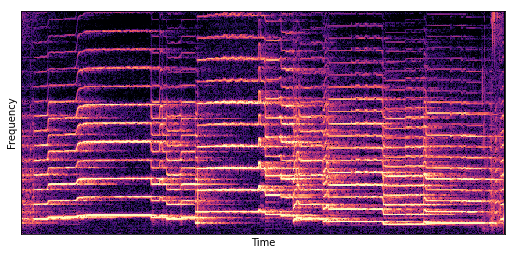

In [ ]:

record_or_upload = "Upload (.mp3 or .wav)" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]

# Add batch dimension
audio = audio[np.newaxis, :]

# Listen.
specplot(audio)
play(audio)

In [ ]:
#print(audio,'\n',audio.size)

###Exmaples

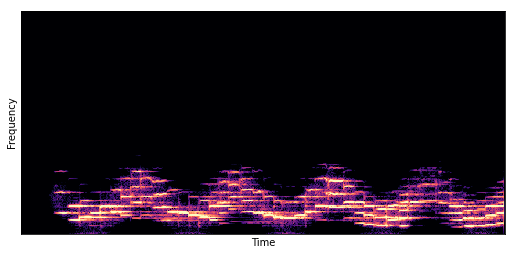

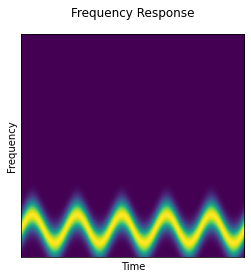

In [ ]:
# Let's make an oscillating gaussian bandpass filter.
fir_filter = ddsp.effects.FIRFilter(scale_fn=None)

# Make up some oscillating gaussians.
n_seconds = audio.size / sample_rate
frame_rate = 100  # Hz
n_frames = int(n_seconds * frame_rate)
n_samples = int(n_frames * sample_rate / frame_rate)
audio_trimmed = audio[:, :n_samples]

n_frequencies = 1000
frequencies = np.linspace(0, sample_rate / 2.0, n_frequencies)

lfo_rate = 0.5  # Hz
n_cycles = n_seconds * lfo_rate
center_frequency = 1000 + 500 * np.sin(np.linspace(0, 2.0*np.pi*n_cycles, n_frames))
width = 500.0
gauss = lambda x, mu: 2.0 * np.pi * width**-2.0 * np.exp(- ((x - mu) / width)**2.0)


# Actually make the magnitudes.
magnitudes = np.array([gauss(frequencies, cf) for cf in center_frequency])
magnitudes = magnitudes[np.newaxis, ...]
magnitudes /= magnitudes.max(axis=-1, keepdims=True)

# Filter.
audio_out = fir_filter(audio_trimmed, magnitudes)

# Listen.
play(audio_out)
specplot(audio_out)
_ = plt.matshow(np.rot90(magnitudes[0]), aspect='auto')
plt.title('Frequency Response')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks([])
_ = plt.yticks([])

#  Filter Noise/Substractive Synthesizer


---- This session partly refers to the colab tutorial[ 1_synths_and_effects](https://colab.research.google.com/drive/17idRTux3Hie3T8fgJ6RbRGKJ3OnXddVJ#scrollTo=Lay_6Ldw93ZL) provided by DDSP Github ----

Natural sounds contain both harmonic and stochastic components. The Harmonic plus Noise model captures this by combining the output of an additive synthesizer with a stream of filtered noise (Serra & Smith, 1990; Beauchamp, 2007). We are able to realize a differentiable filtered noise synthesizer by simply applying the LTV-FIR filter from above to a stream of uniform noise $Y_l = H_lN_l$ where $N_l$ is the IDFT of uniform noise in domain [-1, 1]. $H_l$ is the frequency-domain transfer function of the corresponding FIR filter

The filtered noise synthesizer is a subtractive synthesizer that shapes white noise with a series of time-varying filter banks.

Inputs:

* magnitudes: Amplitude envelope of each filter bank (linearly spaced from 0Hz to the Nyquist frequency).

[Function](https://github.com/magenta/ddsp/blob/master/ddsp/synths.py) we use:
* ddsp.synths.FilteredNoise()

In [ ]:
# class FilteredNoise(processors.Processor):
#   """Synthesize audio by filtering white noise."""

#   def __init__(self,
#                n_samples=64000,
#                window_size=257,
#                scale_fn=core.exp_sigmoid,
#                initial_bias=-5.0,
#                name='filtered_noise'):
#     super().__init__(name=name)
#     self.n_samples = n_samples
#     self.window_size = window_size
#     self.scale_fn = scale_fn
#     self.initial_bias = initial_bias
  # def get_signal(self, magnitudes):
  #   """Synthesize audio with filtered white noise.
  #   Args:
  #     magnitudes: Magnitudes tensor of shape [batch, n_frames, n_filter_banks].
  #       Expects float32 that is strictly positive.
  #   Returns:
  #     signal: A tensor of harmonic waves of shape [batch, n_samples, 1].
  #   """
  #   batch_size = int(magnitudes.shape[0])
  #   signal = tf.random.uniform(
  #       [batch_size, self.n_samples], minval=-1.0, maxval=1.0)
  #   return core.frequency_filter(signal,
  #                                magnitudes,
  #                                window_size=self.window_size)

###Examples

In [ ]:
n_frames = 250
n_frequencies = 1000
n_samples = 64000

# magnitudes: Magnitudes tensor of shape [batch, n_frames, n_filter_banks]. Expects float32 that is strictly positive
# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies)) for w in np.linspace(8.0, 80.0, n_frames)] #dimension: 250*1000
#print(np.size(magnitudes))
magnitudes = 0.5 * tf.stack(magnitudes)**4.0  #Stacks a list of rank-R tensors into one rank-(R+1) tensor.
magnitudes = magnitudes[tf.newaxis, :, :]

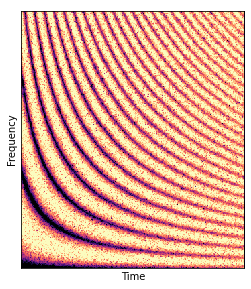

In [ ]:
# Create synthesizer object.
filtered_noise_synth = ddsp.synths.FilteredNoise(n_samples=n_samples, 
                                                 scale_fn=None)

# Generate some audio.
audio = filtered_noise_synth(magnitudes)
# signal: A tensor of harmonic waves of shape [batch, n_samples, 1].

# Listen.
play(audio)
specplot(audio)

In [ ]:
#print(tf.size(audio[0]))

#  Reverb: Long Impulse Response

---- This session partly refers to the colab tutorial[ 1_synths_and_effects](https://colab.research.google.com/drive/17idRTux3Hie3T8fgJ6RbRGKJ3OnXddVJ#scrollTo=Lay_6Ldw93ZL) provided by DDSP Github ----

Room reverbation (reverb) is an essential characteristic of realistic audio, which is usually implicitly modeled by neural synthesis algorithms. In contrast, we gain interpretability by explicitly factorizing the room acoustics into a post-synthesis convolution step. 

A realistic room impulse response (IR) can be as long as several seconds, corresponding to extremely long convolutional kernel sizes (∼10-100k timesteps). Convolution via matrix multiplication scales as $O(n^3)$, which is intractable
for such large kernel sizes. Instead, we implement reverb by explicitly performing convolution as multiplication in the frequency domain, which scales as $O(nlog(n))$ and does not bottleneck training.

###   [Reverbs function](https://github.com/magenta/ddsp/blob/master/ddsp/effects.py) in ddsp library



There are 3 types of reverberation processors in ddsp:
* ddsp.effects.Reverb( )
* ddsp.effects.ExpDecayReverb( )
* ddsp.effects.FilteredNoiseReverb( )

Unlike other processors, reverbs also have the option to **treat the impulse response as a 'trainable' variable**, and not require it from network outputs. This is helpful for instance if the room environment is the same for the whole dataset. To make the reverb trainable, just pass the kwarg `trainable=True` to the constructor

In [ ]:
# class Reverb(processors.Processor):
#   """Convolutional (FIR) reverb."""

#   def __init__(self,
#                trainable=False,
#                reverb_length=48000,
#                add_dry=True,
#                name='reverb'):
#     """Takes neural network outputs directly as the impulse response.
#     Args:
#       trainable: Learn the impulse_response as a single variable for the entire
#         dataset.
#       reverb_length: Length of the impulse response. Only used if
#         trainable=True.
#       add_dry: Add dry signal to reverberated signal on output.
#       name: Name of processor module.
#     """
#     super().__init__(name=name, trainable=trainable)
#     self._reverb_length = reverb_length
#     self._add_dry = add_dry

In [ ]:
# class ExpDecayReverb(Reverb):
#   """Parameterize impulse response as a simple exponential decay."""

#   def __init__(self,
#                trainable=False,
#                reverb_length=48000,
#                scale_fn=core.exp_sigmoid,
#                add_dry=True,
#                name='exp_decay_reverb'):
#     """Constructor.
#     Args:
#       trainable: Learn the impulse_response as a single variable for the entire
#         dataset.
#       reverb_length: Length of the impulse response.
#       scale_fn: Function by which to scale the network outputs.
#       add_dry: Add dry signal to reverberated signal on output.
#       name: Name of processor module.
#     """
#     super().__init__(name=name, add_dry=add_dry, trainable=trainable)
#     self._reverb_length = reverb_length
#     self._scale_fn = scale_fn

In [ ]:
# class FilteredNoiseReverb(Reverb):
#   """Parameterize impulse response with outputs of a filtered noise synth."""

#   def __init__(self,
#                trainable=False,
#                reverb_length=48000,
#                window_size=257,
#                n_frames=1000,
#                n_filter_banks=16,
#                scale_fn=core.exp_sigmoid,
#                initial_bias=-3.0,
#                add_dry=True,
#                name='filtered_noise_reverb'):
#     """Constructor.
#     Args:
#       trainable: Learn the impulse_response as a single variable for the entire
#         dataset.
#       reverb_length: Length of the impulse response.
#       window_size: Window size for filtered noise synthesizer.
#       n_frames: Time resolution of magnitudes coefficients. Only used if
#         trainable=True.
#       n_filter_banks: Frequency resolution of magnitudes coefficients. Only used
#         if trainable=True.
#       scale_fn: Function by which to scale the magnitudes.
#       initial_bias: Shift the filtered noise synth inputs by this amount
#         (before scale_fn) to start generating noise in a resonable range when
#         given magnitudes centered around 0.
#       add_dry: Add dry signal to reverberated signal on output.
#       name: Name of processor module.
#     """
#     super().__init__(name=name, add_dry=add_dry, trainable=trainable)
#     self._n_frames = n_frames
#     self._n_filter_banks = n_filter_banks
#     self._synth = synths.FilteredNoise(n_samples=reverb_length,
#                                        window_size=window_size,
#                                        scale_fn=scale_fn,
#                                        initial_bias=initial_bias)

###Examples

Saving violon_original.wav to violon_original (2).wav


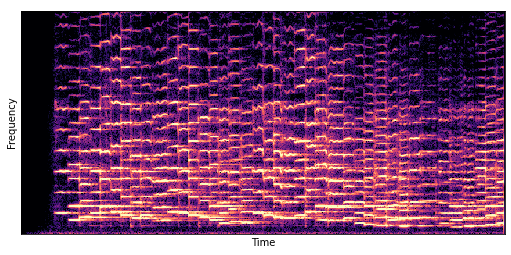

In [ ]:
# Upload  Audio 
record_or_upload = "Upload (.mp3 or .wav)" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]

# Add batch dimension
audio = audio[np.newaxis, :]

# Listen.
specplot(audio)
play(audio)

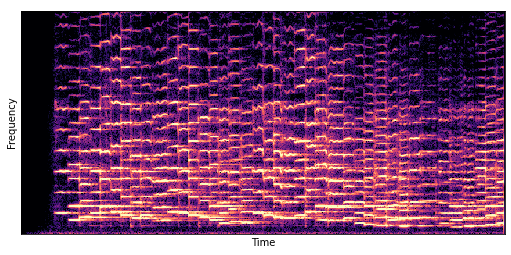

In [ ]:
# a simple reverb
# Let's just do a simple exponential decay reverb.
reverb = ddsp.effects.Reverb(reverb_length=48000)

gain = [[-2.0]]
# gain: Linear gain of impulse response. Scaled by self._gain_scale_fn.

audio_out = reverb(audio, gain)

# Listen.
specplot(audio_out)
play(audio_out)

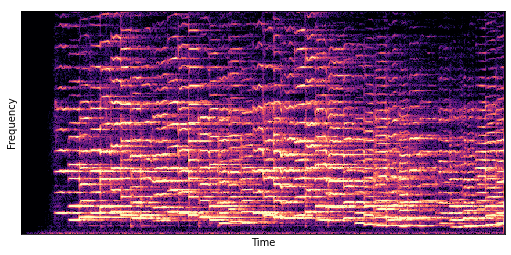

In [ ]:
# Let's just do a simple exponential decay reverb.
reverb = ddsp.effects.ExpDecayReverb(reverb_length=48000)

gain = [[-2.0]]
decay = [[2.0]]
# gain: Linear gain of impulse response. Scaled by self._gain_scale_fn.
# decay: Exponential decay coefficient. The final impulse response is
#          exp(-(2 + exp(decay)) * time) where time goes from 0 to 1.0 over the
#          reverb_length samples.

audio_out = reverb(audio, gain, decay)

# Listen.
specplot(audio_out)
play(audio_out)

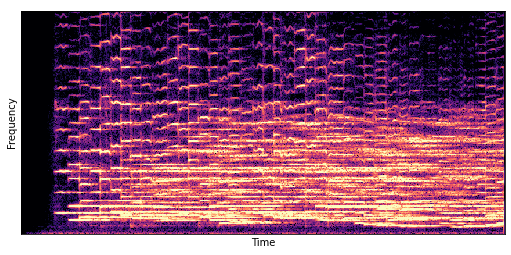

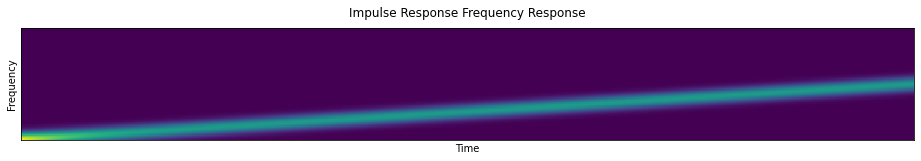

In [ ]:
# Just the filtered noise reverb can be quite expressive.
reverb = ddsp.effects.FilteredNoiseReverb(reverb_length=48000,
                                          scale_fn=None)

# Rising gaussian filtered band pass.
n_frames = 1000
n_frequencies = 100

frequencies = np.linspace(0, sample_rate / 2.0, n_frequencies)
center_frequency = 4000.0 * np.linspace(0, 1.0, n_frames)
width = 500.0
# Gaussian function
gauss = lambda x, mu: 2.0 * np.pi * width**-2.0 * np.exp(- ((x - mu) / width)**2.0)

# Actually make the magnitudes.
magnitudes = np.array([gauss(frequencies, cf) for cf in center_frequency])
magnitudes = magnitudes[np.newaxis, ...]
magnitudes /= magnitudes.sum(axis=-1, keepdims=True) * 5

# Apply the reverb.
audio_out = reverb(audio, magnitudes)

# Listen.
specplot(audio_out)
play(audio_out)
plt.matshow(np.rot90(magnitudes[0]), aspect='auto')
plt.title('Impulse Response Frequency Response')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks([])
_ = plt.yticks([])